### TopN Simple Wines Recommender System From A Wine Name
#### Rogério Xavier de Azambuja (rogerio.xavier@farroupilha.ifrs.edu.br)
#### Dataset X-Wines from https://github.com/rogerioxavier/X-Wines

In [1]:
# Opening required packages for processing
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix as csr
from sklearn.neighbors import NearestNeighbors as nn
# Opening required packages to show output
from matplotlib import pyplot as plt
import cv2 as cv

In [2]:
import pandas as pd
# Opening X-Wines dataset
wines   = pd.read_csv("XWines_100K.csv", low_memory=False, encoding="utf-8", memory_map=True)
ratings = pd.read_csv("XWines_ratings_21M.csv", low_memory=False, encoding="utf-8", memory_map=True)
len(wines), len(ratings)

(100646, 21013536)

In [3]:
print("Total wines:", wines.WineID.nunique(), "from", wines.Code.nunique() ,"different countries")
print("Total users:", ratings.UserID.nunique(), "who rated the wines in", ratings.Language.nunique() ,"different languages")
print(f"             in the period between {ratings.Date.min()} and {ratings.Date.max()}")
print("Total ratings:", len(ratings), f"5-stars on wine vintages since {ratings.Vintage.min()}, including non-vintage 'N.V.'")

Total wines: 100646 from 60 different countries
Total users: 1056079 who rated the wines in 63 different languages
             in the period between 2012-01-03T08:20:53Z and 2021-12-31T23:59:56Z
Total ratings: 21013536 5-stars on wine vintages since 1950, including non-vintage 'N.V.'


In [4]:
# A first segmentation because the dataset is too big
code = 'PT'
country = 'Portugal'
language = 'pt'

In [5]:
winesCode = wines.loc[ wines.Code==code ]
print(winesCode.WineID.nunique(), f"wines from the country {country}({code}) ")

4966 wines from the country Portugal(PT) 


In [6]:
ratingsLang = ratings.loc[ ratings.Language==language ]
print(ratingsLang.UserID.nunique(), f"users for {language} language")
print(len(ratingsLang), f"ratings for {language} language")

195833 users for pt language
3996764 ratings for pt language


In [7]:
# Data preparation for wine recommendation
ratingsLang = ratingsLang.sort_values(['Date'], ascending=False)
ratingsLang = ratingsLang.drop_duplicates(subset=['UserID', 'WineID'], keep='first')
ratingsLang = pd.merge(ratingsLang, winesCode.WineID, how="inner", on=['WineID'])
print(len(ratingsLang), f"unique last ratings from {language} language's users about {code} wines")

766001 unique last ratings from pt language's users about PT wines


In [8]:
# Cut-off point for training on the most relevant data
mostRatingsWines = ratingsLang.groupby('WineID', as_index=False)['Rating'].count()
mostRatingsWines.rename(columns={'Rating':'Frequency'}, inplace=True)
mostRatingsWines = mostRatingsWines.loc[ mostRatingsWines.Frequency>50 ]
print(len(mostRatingsWines), "most ratings wines")

mostRatingsUsers = ratingsLang.groupby('UserID', as_index=False)['Rating'].count()
mostRatingsUsers.rename(columns={'Rating':'Frequency'}, inplace=True)
mostRatingsUsers = mostRatingsUsers.loc[ mostRatingsUsers.Frequency>25 ]
print(len(mostRatingsUsers), "most ratings users")

2317 most ratings wines
3945 most ratings users


In [9]:
# Data segmentation for collaborative filtering
colabRatings = pd.merge(ratingsLang,  mostRatingsWines.WineID, how="inner", on=['WineID'])
print(colabRatings.WineID.nunique(), "most ratings wines")
colabRatings = pd.merge(colabRatings, mostRatingsUsers.UserID, how="inner", on=['UserID'])
print(colabRatings.UserID.nunique(), "most ratings users")
print(len(ratingsLang),'to', len(colabRatings), 'useful ratings for collaborative filtering')

2317 most ratings wines
3945 most ratings users
766001 to 177847 useful ratings for collaborative filtering


In [10]:
# Data matrix for collaborative filtering
colabRatings = colabRatings.pivot(index='WineID', columns='UserID', values='Rating').fillna(0)
print("Sparse matrix dimension: ", colabRatings.shape)
colabRatings.head()

Sparse matrix dimension:  (2301, 3945)


UserID,1000010,1000025,1000045,1000088,1000097,1000144,1000151,1000184,1000219,1000220,...,2056107,2056118,2056577,2057551,2057813,2060099,2060555,2061799,2061816,2062382
WineID,,,,,,,,,,,,,,,,,,,,,
100010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
100012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100014,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101563,0.0,4.0,0.0,4.0,4.0,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Best treatment for sparse matrix through spicy csr_matrix
colabMatrix = csr(colabRatings.values)
# network training using basic parameters and only colaboration values
colabKNN = nn(n_neighbors=15, metric='cosine', n_jobs=-1)
colabKNN.fit(colabMatrix)
# reset the first UserID index because only wines will be recommended
# makes the indices one-dimensional equivalent to colabMatrix position
colabRatings.reset_index(inplace=True)

In [12]:
# TopN simple recommender from a wine name
def recommenderKNN(wineName, nRecommendation=10):
    listWines = winesCode.loc[ winesCode.WineName.str.contains(wineName, case=False) ][:3]
    if len(listWines) == 0:
        print("Bad input to find wines")
        return (pd.DataFrame())
    else:
        for i in range(0,3):
            try:
                # from the first wine found
                wineID       = listWines.iloc[i]['WineID']
                # your position in the network
                indexWine    = colabRatings.loc[ colabRatings.WineID == wineID ].index[0]
                break
            except:
                continue
        # capture the index of its topN nearest neighbors
        similarities, indexes = colabKNN.kneighbors(colabMatrix[indexWine], n_neighbors=nRecommendation+1)
        # return the neighbors using their indexes and similarity
        recList = []
        for (s, i) in zip(similarities[0], indexes[0]):
            wineID = int(colabRatings.iloc[ i ]['WineID'])
            wine = winesCode.loc[ winesCode.WineID == wineID ][['WineID', 'WineName']].values[0]
            recList.insert(0, {'WineID':wine[0], 'WineName':wine[1], 'Similarity':round(s, 5)})
        recList.sort(key=lambda i: i['Similarity'], reverse=True)
        return (pd.DataFrame(recList))

def show10wines(df=pd.DataFrame()):
    if len(df) == 0:
        print("Bad input to show wines")
        return 
    else:
        if len(df)==1:
            plt.figure(figsize=(25, 10))
        else:
            plt.figure(figsize=(50, 20))
        i = 1
        for (wineID, wineName) in (zip(df.WineID[:10], df.WineName[:10])):
            plt.subplot(2,5,i), plt.imshow( cv.imread(f"images/{wineID}.jpeg",1) )
            plt.title("\n"+wineName, fontsize=35)
            plt.xticks([]),plt.yticks([])
            i+=1
        plt.show()       
        return

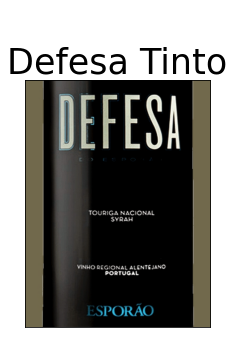

10 recommendations considering wine: 100010 Defesa Tinto 

   WineID                       WineName  Similarity
0  101599             Vinha Grande Douro     0.83343
1  101582                  Chaminé Tinto     0.83210
2  101712                  Courela Tinto     0.83191
3  101563          Esporão Reserva Tinto     0.82977
4  101564               Papa Figos Douro     0.82521
5  101565           Évora Colheita Tinto     0.82210
6  101613  Cabeça de Toiro Reserva Tinto     0.81778
7  101573                       EA Tinto     0.81312
8  101566              Monte Velho Tinto     0.79552
9  101569                   Esteva Douro     0.78585


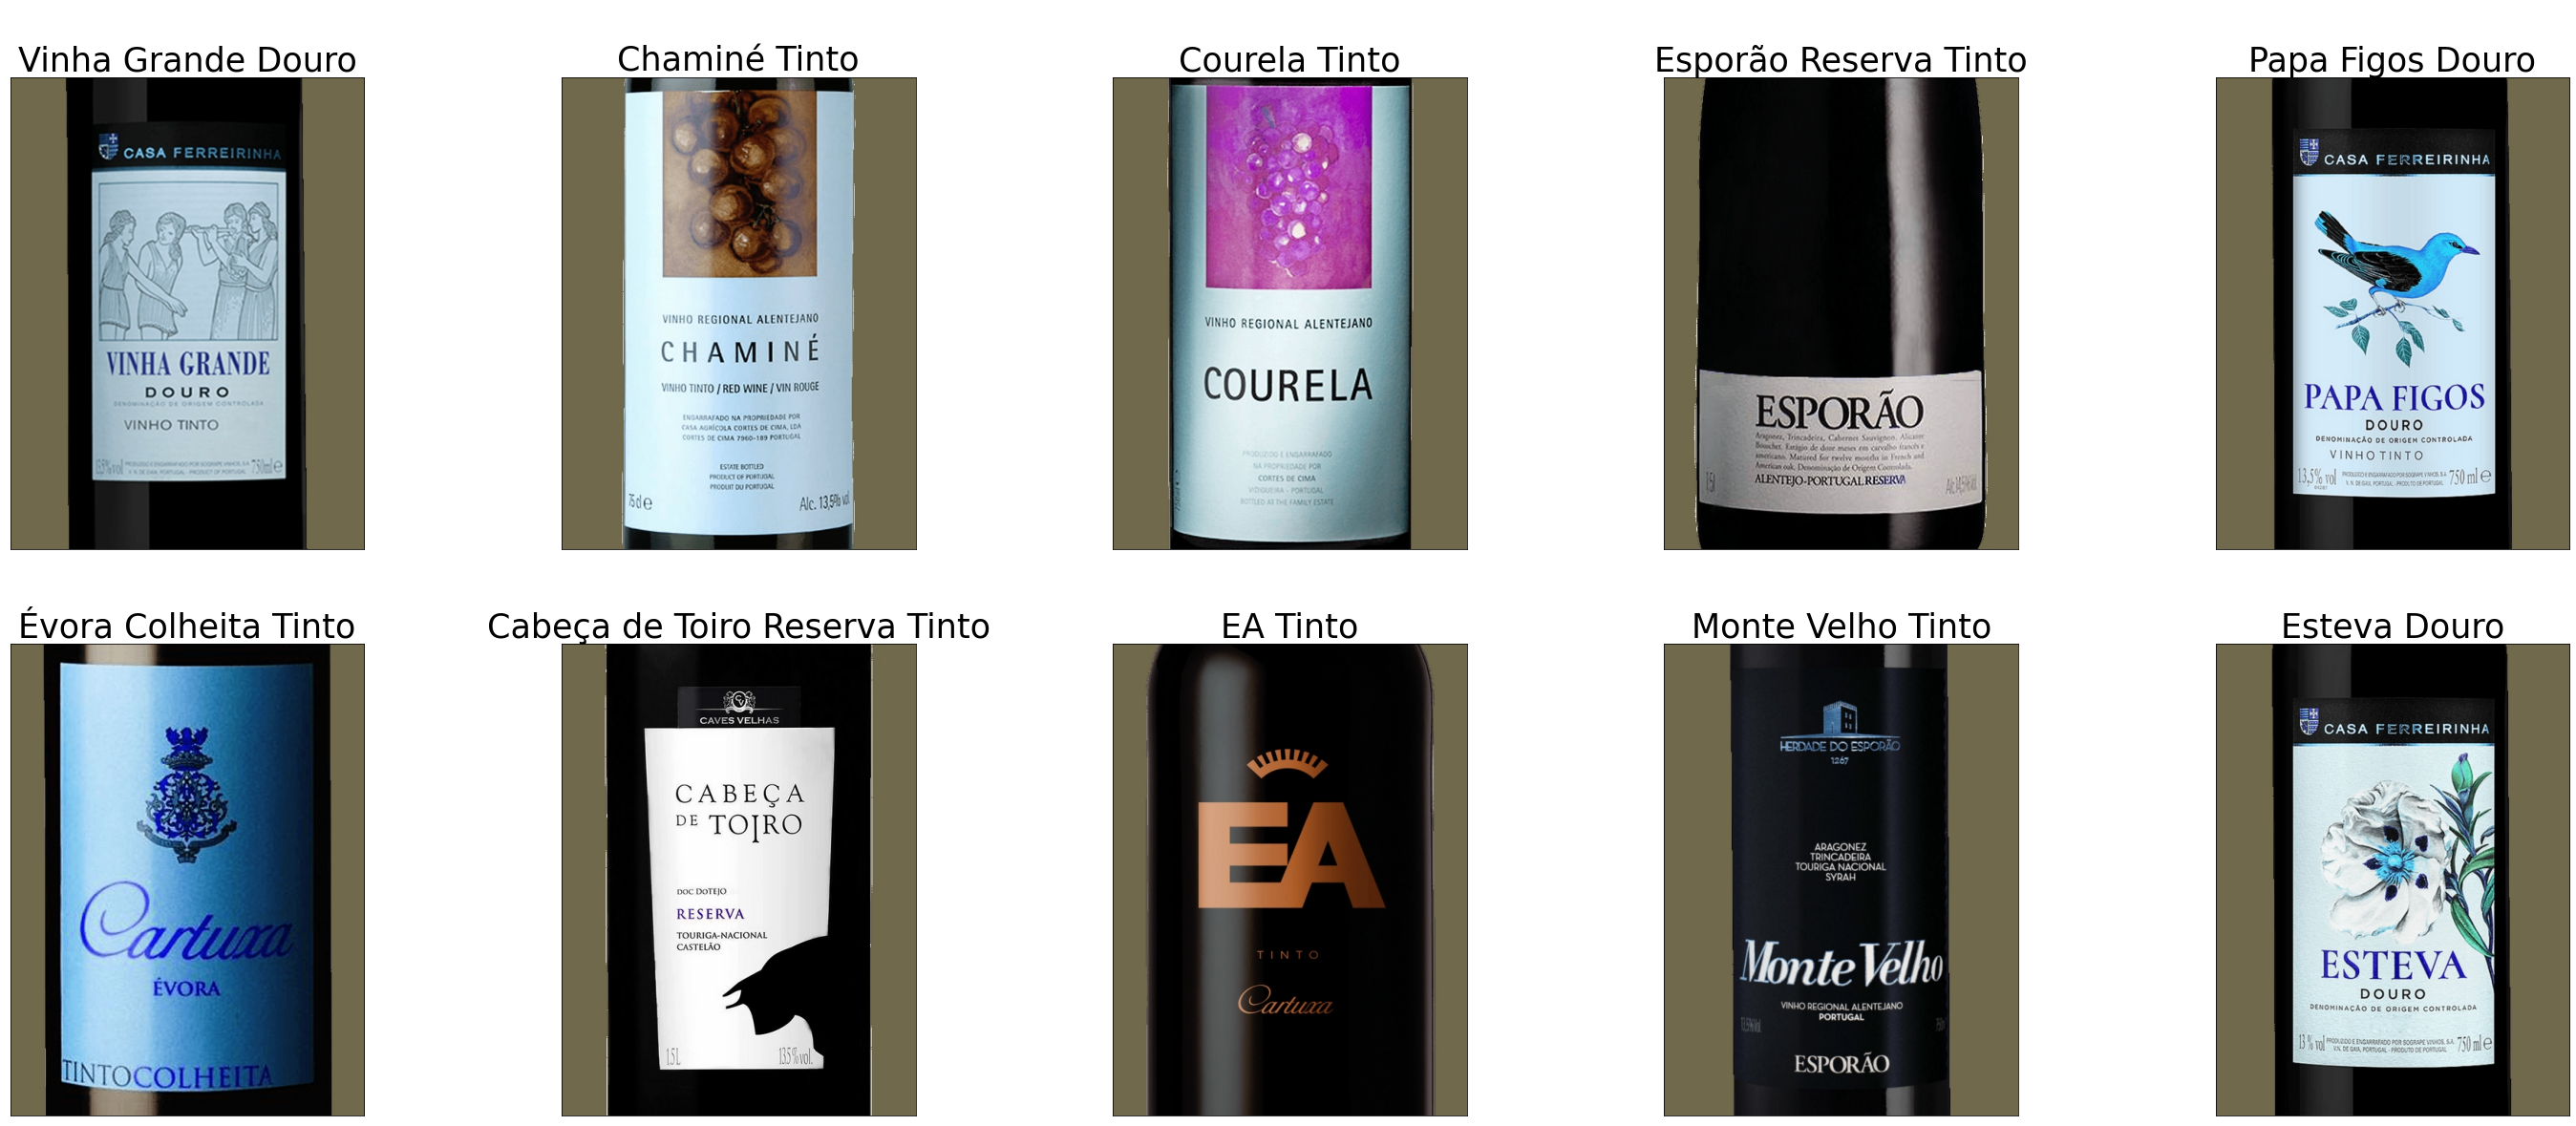

In [13]:
topN = 10; wineStartName = "Defesa"
recWines = recommenderKNN(wineStartName, topN)
if len(recWines)>0:
    # The last wine in the list is the starting wine with similarity = 0
    show10wines(recWines[topN:])
    print(topN,'recommendations considering wine:',recWines.WineID[topN],recWines.WineName[topN],"\n")
    # Shows recommended wines
    print(recWines.head(topN))
    show10wines(recWines[:topN])

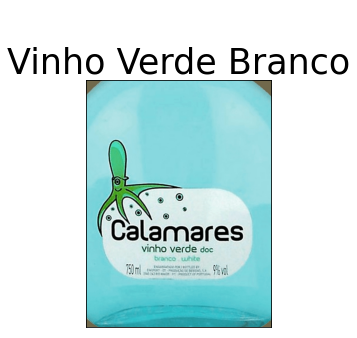

5 recommendations considering wine: 100012 Vinho Verde Branco 

   WineID                  WineName  Similarity
0  103732                    Branco     0.85387
1  101640                Vinho Rosé     0.85057
2  101601             Alandra Tinto     0.84237
3  102297           Alto Vez Branco     0.82958
4  101655  Casal Mendes Vinho Verde     0.79324


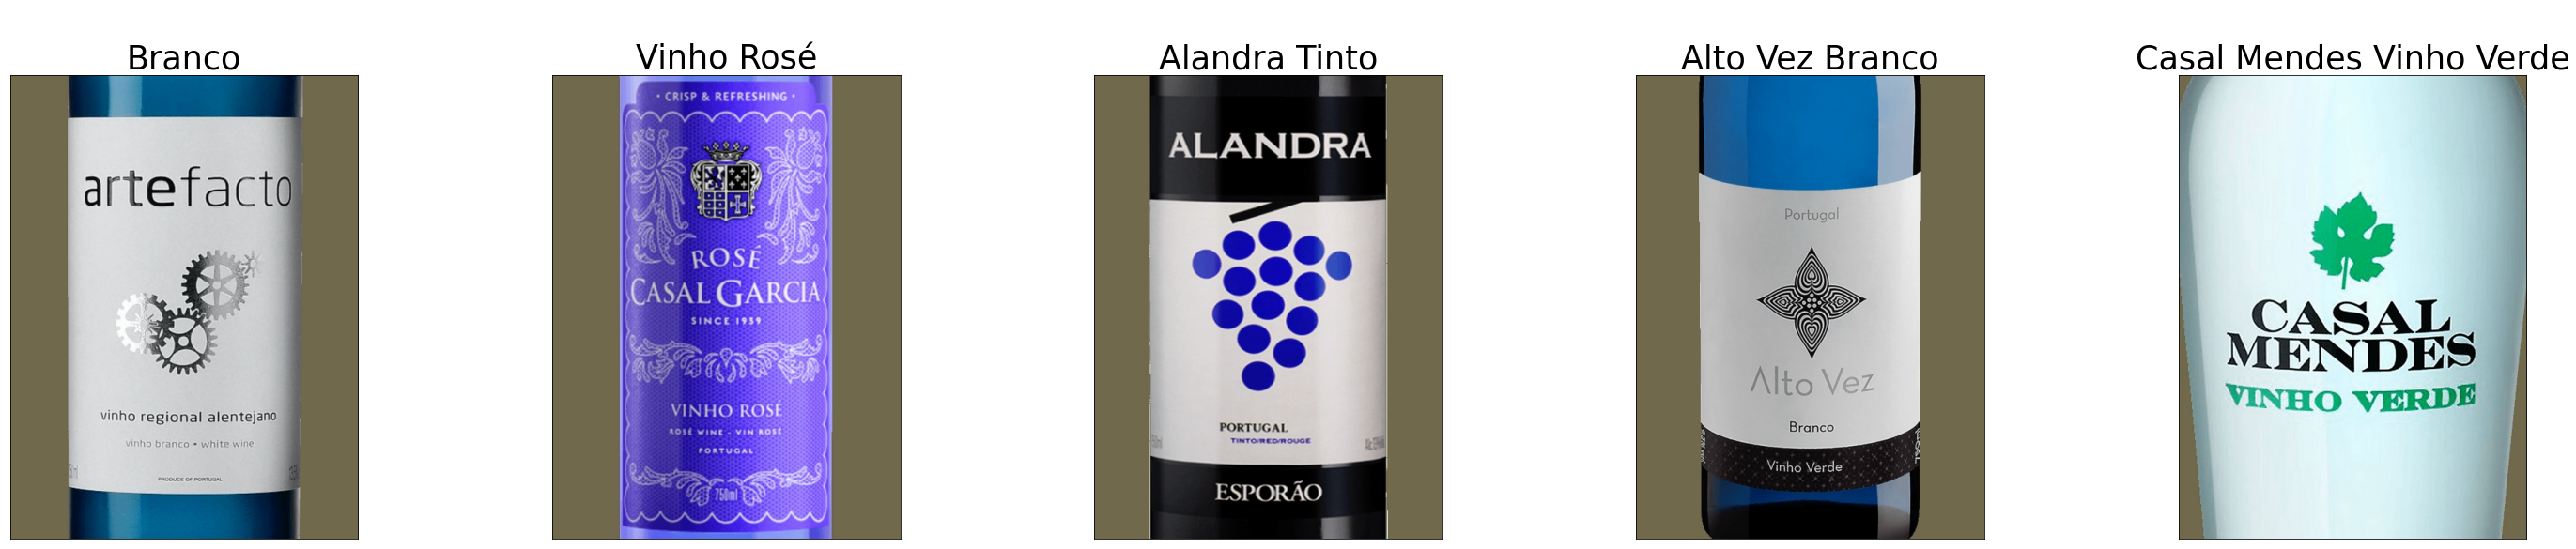

In [14]:
topN = 5; wineStartName = "Vinho Verde"
recWines = recommenderKNN(wineStartName, topN)
if len(recWines)>0:
    # The last wine in the list is the starting wine with similarity = 0
    show10wines(recWines[topN:])
    print(topN,'recommendations considering wine:',recWines.WineID[topN],recWines.WineName[topN],"\n")
    # Shows recommended wines
    print(recWines.head(topN))
    show10wines(recWines[:topN])